In [1]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


## Setup

Set `PLANET_KAGGLE_ROOT` to the proper directory where we've got the TIFF and JPEG zip files, and accompanying CSVs.

In [3]:
PLANET_KAGGLE_ROOT = os.path.abspath("input/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg/train-jpg/')
PLANET_KAGGLE_TIF_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect image labels
The labels are in a CSV entitled train.csv. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [4]:
!ls -lha input/train.csv

-rw-r--r--@ 1 Mel  staff   1.4M Apr 18 17:47 input/train.csv


In [5]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [7]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [8]:
labels_df.to_csv('labels_onehotencoding.csv')

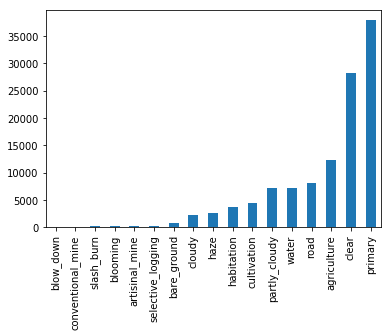

In [9]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [10]:
# Plot a TIF image 
def plotImage(fileName, outFile):
    '''
    Plot the three color bands for an image

    Automatically detect the number of color bands the 
    image has, and plot the image so that it is easy to 
    visualize all the color bands
    '''

    print fileName

    img      = io.imread(fileName)
    numBands = img.shape[-1]

    plt.figure(figsize=(5*(numBands+1), 5)) # One for the original image
    f = 1.0/(numBands+1)
    for b in range(numBands):
        plt.axes( [b * f, 0, f, 1] )
        plt.imshow(img[ :, :, b], cmap=plt.cm.viridis)
        plt.xticks([]); plt.yticks([])

    if numBands == 4:
        img1 = img[ :, :, :-1].copy()
        img1 = img1*255.0/img1.max()
        img2 = np.zeros(np.shape(img1))
        img2[:,:,0] = img1[:,:,2]
        img2[:,:,1] = img1[:,:,1]
        img2[:,:,2] = img1[:,:,0]
        img2 = img2.astype(np.uint8)
    else:
        img2 = img

    plt.axes( [(b+1) * f, 0, f, 1] )
    plt.imshow(img2)
    plt.xticks([]); plt.yticks([])

    plt.savefig(outFile)
    plt.close('all')

    return img

## JPEG Images

In [11]:
from glob import glob
image_paths = sorted(glob('input/train-jpg/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

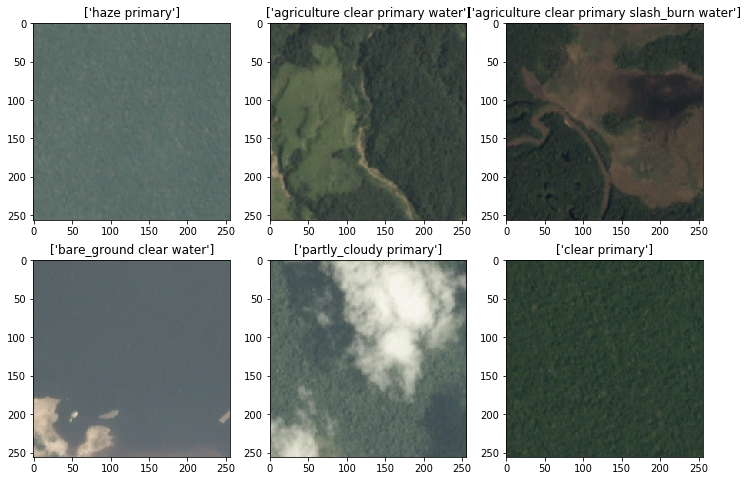

In [12]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(labels_df[labels_df.image_name == image_names[i]].tags.values))

All images have same size (256,256).

In [13]:
from PIL import Image

im = Image.open('input/train-jpg/train-jpg/train_40387.jpg')
print 'width: %d - height: %d' % im.size # returns (width, height) tuple

width: 256 - height: 256


## Prepare data as input for a Keras NN

 Use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

In [14]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [15]:
# Randomly select indices for training and validation sets
n_dataset = len(labels_df.index)
print n_dataset

40479


In [16]:
PLANET_KAGGLE_JPEG_DIR

'/Users/Mel/Documents/Berkeley3A/DMA (Data Mining and Analytics)/Planet_Kaggle/input/train-jpg/train-jpg/'

In [17]:
im = Image.open('input/train-jpg/train-jpg/train_0.jpg')
imarray = np.array(im)
print imarray.shape

(256, 256, 4)


In [18]:
"""
for impath in glob('input/train-jpg/train-jpg/*.jpg'):
    im = Image.open(impath)
    imarray = np.array(im)
    
print imarray.shape, im.size
""" 

"\nfor impath in glob('input/train-jpg/train-jpg/*.jpg'):\n    im = Image.open(impath)\n    imarray = np.array(im)\n    \nprint imarray.shape, im.size\n"

In [19]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [20]:
testpath = 'input/train-jpg/train-jpg/train_0.jpg'
arrayimg=load_image(testpath)
arrayimg.shape

(256, 256, 4)

In [21]:
# TOO SLOW - RUNNING OUT OF MEMORY 
"""
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg/train-jpg/')

list_img_array = []
for root, dirs, filenames in os.walk(PLANET_KAGGLE_JPEG_DIR):
    for f in filenames:
        fullpath = open(os.path.join(root, f), 'r')
        img_array = load_image(fullpath)
        list_img_array.append(img_array)
"""


"\nPLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg/train-jpg/')\n\nlist_img_array = []\nfor root, dirs, filenames in os.walk(PLANET_KAGGLE_JPEG_DIR):\n    for f in filenames:\n        fullpath = open(os.path.join(root, f), 'r')\n        img_array = load_image(fullpath)\n        list_img_array.append(img_array)\n"

In [22]:
image_paths = sorted(glob('input/train-jpg/train-jpg/*.jpg'))[0:1000]
list_img_array = []
img_height= 256
img_width = 256
n_dataset = len(labels_df.index)
#img_arrays=np.empty((n_dataset, img_height, img_width, 4))
for impath in image_paths:
    img_array = load_image(impath)
    list_img_array.append(img_array)    

In [23]:
X = np.array(list_img_array)

In [24]:
X.shape

(1000, 256, 256, 4)

In [25]:
labels_df.drop(['image_name', 'tags'], axis=1).as_matrix()

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [26]:
# Take the subset of labels from X (we only took 1000 samples!)

list_labels=[]
for impath in image_paths:
    label = int(impath.strip('.jpg').split('_')[-1])
    list_labels.append(label)
#print list_labels    

In [27]:
# Take the y corresponding to the X subset
y = np.take(labels_df.drop(['image_name', 'tags'], axis=1).as_matrix(), indices = list_labels, axis=0)
y.shape

(1000, 17)

In [28]:
from sklearn.model_selection import train_test_split
X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=None)

In [29]:
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(670, 256, 256, 4) (670, 17)
(330, 256, 256, 4) (330, 17)


In [30]:
#train_data_dir = PLANET_KAGGLE_JPEG_DIR
img_width=256
img_height=256
batch_size = 50 
#nb_train_samples = 2000
#nb_validation_samples = 800

datagen = ImageDataGenerator(
        featurewise_center=True, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=True, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0, # randomly shift images vertically (fraction of total height)
        horizontal_flip=False, # randomly flip images
        vertical_flip=False) # randomly flip images


from keras import applications
model = applications.VGG16(include_top=False, weights='imagenet')

#y_train = y_train.reshape((-1, 1))
train_generator = datagen.flow( X_train, y_train,
                         batch_size=batch_size,
                         shuffle=True)

test_generator = datagen.flow( X_test, y_test,
                         batch_size=batch_size,
                         shuffle=True)


# issue because vgg16 does not work with categorical cross-entropy

## Build a NN suited to multi-label classification

In [31]:
# taken from https://github.com/suraj-deshmukh/Multi-Label-Image-Classification/blob/master/miml.ipynb
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', data_format="channels_last", input_shape=(256, 256, 4)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('sigmoid'))

In [32]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [39]:
# checkpoint model
from keras.callbacks import ModelCheckpoint
filepath='weights-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val-acc', verbose=1, save_best_only=True, mode='max')
callbacks_list=[checkpoint]

In [40]:
model.fit_generator(train_generator,
                    steps_per_epoch= y_train.shape[0] // batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=y_test.shape[0] // batch_size, callbacks=callbacks_list)


Epoch 1/10
13/13 [==============================] - 1211s - loss: 2.6995 - acc: 0.8314 - val_loss: 2.3873 - val_acc: 0.8511

In [41]:
model.save_weights('first_try.h5')  # always save your weights after training or during training

In [44]:
# Code not tested yet
# check this: https://github.com/suraj-deshmukh/Multi-Label-Image-Classification/blob/master/miml.ipynb
# and this : https://github.com/fchollet/keras/issues/741
# Need to create new test generator
preds = model.predict_generator(new_test_generator, steps= y_new_test.shape[0])

NameError: name 'new_test_generator' is not defined

In [45]:
threshold = [] # thereshold for predictions as a list of 17 thresholds for the 17 classes
y_preds = np.array([1 if preds[0,i]>=threshold[i] else 0 for i in range(preds.shape[1])])

NameError: name 'preds' is not defined